<h2>Trabalho Prático 1</h2>
<h3>Redes Neuronais + Backpropagation</h3>

<h3 style='color:blue'>Nome: Marcelo Nunes da Silva <br>Turma: PG9 - Isolada</h3>

<p>Neste trabalho você irá implementar uma rede neuronal com três camadas:

1. Camada de entrada: cada unidade representa uma dimensão do dado de entrada.

2. Camada oculta: cada unidade representa uma transformação a partir das unidades de entrada.

3. Camada de saída: cada unidade representa a chance da saída correspondente ser a correta.

Você irá utilizar a função **Sigmóide** para obter não-linearidade. Além disso, a função de perda a ser minimizada é a seguinte:</p>
<img src='loss.png'/>
<p>onde m é a quantidade de entradas no treino, K é o número de saídas possíveis,  representa a saída correta de cada classe k em cada entrada (i), e similarmente representa a saída dada pela rede neuronal.

O dado a ser utilizado está anexado. Trata-se de 5000 entradas, onde cada entrada refere-se a um dígito escrito manualmente (i.e., MNIST dataset). Dessa forma, m=5000 e K=10. Cada entrada é dada por uma matriz de dimensões 28 por 28, ou seja, um vetor de 784 dimensões. A primeira coluna do arquivo sempre é o rótulo do dígito correto.

A rede neuronal a ser implementada deverá ter 784 unidades de entrada e 10 unidades de saída. Em seus experimentos, você deverá variar o número de unidades na camada oculta (25, 50, 100).

Além disso, você deverá comparar os seguintes algoritmos de cálculo de gradiente:

1. Gradient Descent: o gradiente é calculado após cada época (após as 5000 entradas serem processadas).

2. Stochastic Gradient Descent: o gradiente é calculado após cada entrada.

3. Mini-Batch: o gradiente é calculado após um certo número de entradas (considere 10 e 50).

Por fim, você também deverá variar a taxa de aprendizado: 0.5, 1, 10.

O documento a ser entregue deverá apresentar o resultado de seus experimentos. Ou seja, deverá apresentar discussão da variação do número de unidades na camada oculta para cada um dos três algoritmos de cálculo de gradiente. Você deverá apresentar gráficos mostrando a convergência do erro empírico para cada situação (unidades na camada oculta, algoritmo de cálculo do gradiente, taxa de aprendizado). Você deverá deixar claras todas as hipóteses que julgar serem pertinentes.</p>

#### Instalação e import de libs

In [1]:
#!pip install keras

#!pip install tensorflow

#!pip install scikit-learn

#!pip install tqdm

In [3]:
import warnings
warnings.filterwarnings('ignore')

import time
import numpy as np
import pandas as pd
import pickle as pkl
import tensorflow as tf
from tensorflow import keras
from keras.optimizers import SGD
from matplotlib import pyplot as plt
from sklearn.model_selection import KFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Dense, Input)
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

##### Leitura do dado

In [10]:
with open('data_tp1', 'r') as f:
    df = f.readlines()

# Conversão de linhas em uma lista de listas
df = [row.replace('\n', '').split(',') for row in df]

##### Separação X e y

In [11]:
# 1ª coluna são as labels (enunciado)
y = [row[0] for row in df]

# 2ª em diante são os dados da imagem (enunciado)
X = [row[1:] for row in df]
X = np.array(X, dtype='float')

##### Converte cada y de string (exemplo: '7') para vetor one hot encoding (exemplo: [0 0 0 0 0 0 0 1 0 0])

In [12]:
y_one_hot = pd.DataFrame(y, columns=['category'])
y_one_hot = pd.get_dummies(y_one_hot['category'])
y_one_hot = y_one_hot.to_numpy()

##### Conversão dos 784 valores de cada entrada para o tamanho 28x28 em outra  variável (apenas para imprimir alguns dígitos)

In [13]:
X_reshaped = np.reshape(X, [5000, 28, 28])

##### Checando tamanho das variáveis

In [14]:
print("Check entry of y, and y converted using one hot encoding")
display(y[0], y_one_hot[0])
print("=" * 100)

print("Continuous array image (m=5000 inputs)")
display(X.shape)
print("=" * 100)

print("Reshaped array to plot the images (m=5000 inputs)")
display(X_reshaped.shape)
print("=" * 100)

print("Check y size and y_one_hot size")
display(len(y), y_one_hot.shape)

Check entry of y, and y converted using one hot encoding


'7'

array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0], dtype=uint8)

Continuous array image (m=5000 inputs)


(5000, 784)

Reshaped array to plot the images (m=5000 inputs)


(5000, 28, 28)

Check y size and y_one_hot size


5000

(5000, 10)

##### Imprimindo alguns dígitos para visualizar as entradas

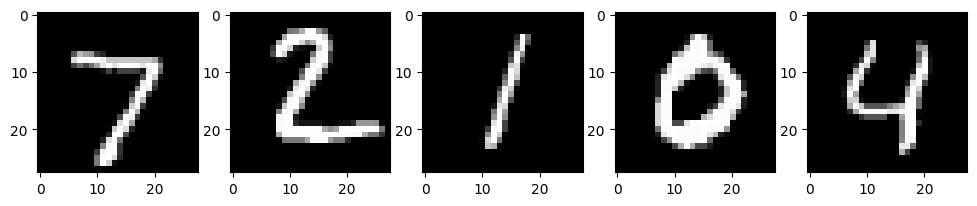

In [15]:
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=[12, 12])
for i in range(5):
    ax[i].imshow(X_reshaped[i], cmap='gray')
plt.show()

##### Função que cria o modelo <br>Recebe o número de neurônios da camada oculta, e a taxa de aprendizado.<br>Ambos parâmetros serão tunnados e comparados a seguir.<br> O batch size será tunado na chamada do método .fit() do modelo

In [16]:
def create_model(n_neurons, learning_rate):
    # Uso da biblioteca Keras
    model = Sequential()
    
    # Primeira camada (784 de tamanho em cada entrada)
    model.add(Input(X.shape[1]))
    
    # Camada oculta
    # Número de neurônios irá variar
    model.add(Dense(n_neurons, activation='sigmoid'))
    
    # Camada de saída com 10 valores (vetor com valor 1 no dígito previsto e 0 nos demais)
    model.add(Dense(10, activation='softmax'))

    # Compilação do modelo com uso da LOG LOSS (essa é a loss apresentada no enunciado do trabalho)
    # e usei a categorical_crossentropy por causa da explicação que a documentação do keras apresenta:
    #
    # `Use this crossentropy loss function when there are two or more label classes. 
    # We expect labels to be provided in a one_hot representation`
    #
    # além disso, uso do Stochastic Gradient Descent aqui, mas com variação do batch_size
    # na etapa de treinamento para variar entre Batch SGD, SGD e GD
    # e variação da taxa de aprendizado
    model.compile(
        loss='categorical_crossentropy', # Log loss (ou entropia cruzada)
        optimizer=SGD(lr=learning_rate), # Taxa de aprendizado
        metrics=['accuracy'] # Métrica extra
    )
    return model

#### Quebra do dado em treino, e teste. Validação feita no próprio .fit(). <br>Estou usando 15% de tamanho para o dataset de teste e  15% para o dataset de validação (valores arbitrários). <br>Poderia não usar um dado de teste, e apenas minimizar meu erro empírico, <br>mas isso faria o modelo sofrer overfitting, e não poderíamos tirar conclusões fora da amostra

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y_one_hot, test_size=0.15, random_state=42)

##### Definição dos parâmetros que serão variados (de acordo com o enunciado do trabalho)

In [18]:
n_neurons_list = [25, 50, 100]
batch_size_list = [1, 10, 50, 5000]
learning_rate_list = [0.5, 1, 10]

In [19]:
epochs = 100

# Usando early stopping apenas para capturar a melhor loss obtida,
# e usá-la na hora de avaliar o df de teste. Observe que usei o patience igual ao tamanho das épocas
# para não aplicar o early stopping (conforme professor disse em sala que não era benéfico)
early_stop = EarlyStopping(
    monitor='val_loss',
    mode='min',
    patience=epochs,
    restore_best_weights=True
)

##### Results: dataframe com cada parâmetro e resultado de loss e acurácia obtido em cada entrada. <br>Considerando as listas acima, teremos 3 x 4 x 3 = 36 valores nesse dataframe.
##### Histories: lista de listas, que armazenará as loss em cada uma das 36 execuções

In [13]:
results = pd.DataFrame()
histories = []

##### [IMPORTANTE] Execuções da lista de parâmetros. Em cada execução é calculado o erro de validação, e a acurácia no dataset de validação, e armazenados no dataframe results. <br> Além disso, o histórico de loss no treino e na validação são armazenados no histories <br> Apliquei verbose 0 no .fit() rede, pois visualizaremos as losses agrupadas ao final do documento.

In [92]:
for n_neurons in n_neurons_list:
    for batch_size in batch_size_list:
        for learning_rate in learning_rate_list:

            print("=" * 100)
            start = time.time()

            model = create_model(n_neurons, learning_rate)

            # Treino do modelo. Aqui estamos aplicando a variação do batch_size
            # e usando os 15% de tamanho do df de validação
            history = model.fit(x=X_train, 
                                y=y_train, 
                                validation_split=0.15,
                                epochs=epochs, 
                                batch_size=batch_size, 
                                callbacks=[early_stop],
                                verbose=0)

            # Avaliação do modelo no dado fora da amostra, para avaliar apenas a saída final
            # no dataset results
            loss, accuracy = model.evaluate(X_test, y_test)

            time_spent = round(time.time() - start, 2)

            single_output = pd.DataFrame.from_dict({
                'n_neurons': [n_neurons],
                'batch_size': [batch_size],
                'learning_rate': [learning_rate],
                'test_loss': [round(loss,2)],
                'test_accuracy': [round(accuracy, 2)],
                'time_spent': [time_spent]
            })

            display(single_output)
            print(f"Time spent: {time_spent} seconds.")

            results = results.append(single_output)
            results.to_csv("results.csv", index=False)

            histories.append(history.history)
            with open('histories.pkl','wb') as f:
                pkl.dump(histories, f)

            print("Done!")

24/24 [==============================] - 0s 2ms/step - loss: 3.5257 - accuracy: 0.0840


n_neurons  batch_size  learning_rate  test_loss  test_accuracy  time_spent
0         25           1            0.5       3.53           0.08      386.43

Time spent: 386.43 seconds.
Done!
24/24 [==============================] - 0s 1ms/step - loss: 5.4275 - accuracy: 0.1133


n_neurons  batch_size  learning_rate  test_loss  test_accuracy  time_spent
0         25           1              1       5.43           0.11      369.41

Time spent: 369.41 seconds.
Done!
24/24 [==============================] - 0s 1ms/step - loss: 60.0516 - accuracy: 0.1027


n_neurons  batch_size  learning_rate  test_loss  test_accuracy  time_spent
0         25           1             10      60.05            0.1      360.67

Time spent: 360.67 seconds.
Done!
24/24 [==============================] - 0s 1ms/step - loss: 4.1857 - accuracy: 0.1213


n_neurons  batch_size  learning_rate  test_loss  test_accuracy  time_spent
0         25          10            0.5       4.19           0.12       43.24

Time spent: 43.24 seconds.
Done!
24/24 [==============================] - 0s 1ms/step - loss: 5.2647 - accuracy: 0.0840


n_neurons  batch_size  learning_rate  test_loss  test_accuracy  time_spent
0         25          10              1       5.26           0.08       43.83

Time spent: 43.83 seconds.
Done!
24/24 [==============================] - 0s 2ms/step - loss: 35.0109 - accuracy: 0.1027


n_neurons  batch_size  learning_rate  test_loss  test_accuracy  time_spent
0         25          10             10      35.01            0.1       43.61

Time spent: 43.61 seconds.
Done!
24/24 [==============================] - 0s 2ms/step - loss: 2.4142 - accuracy: 0.1187


n_neurons  batch_size  learning_rate  test_loss  test_accuracy  time_spent
0         25          50            0.5       2.41           0.12       13.35

Time spent: 13.35 seconds.
Done!
24/24 [==============================] - 0s 1ms/step - loss: 2.8820 - accuracy: 0.1947


n_neurons  batch_size  learning_rate  test_loss  test_accuracy  time_spent
0         25          50              1       2.88           0.19       13.32

Time spent: 13.32 seconds.
Done!
24/24 [==============================] - 0s 1ms/step - loss: 28.2790 - accuracy: 0.1200


n_neurons  batch_size  learning_rate  test_loss  test_accuracy  time_spent
0         25          50             10      28.28           0.12       13.31

Time spent: 13.31 seconds.
Done!
24/24 [==============================] - 0s 2ms/step - loss: 0.6047 - accuracy: 0.8227


n_neurons  batch_size  learning_rate  test_loss  test_accuracy  time_spent
0         25        5000            0.5        0.6           0.82         5.1

Time spent: 5.1 seconds.
Done!
24/24 [==============================] - 0s 2ms/step - loss: 0.5669 - accuracy: 0.8280


n_neurons  batch_size  learning_rate  test_loss  test_accuracy  time_spent
0         25        5000              1       0.57           0.83        4.57

Time spent: 4.57 seconds.
Done!
24/24 [==============================] - 0s 2ms/step - loss: 3.3893 - accuracy: 0.3293


n_neurons  batch_size  learning_rate  test_loss  test_accuracy  time_spent
0         25        5000             10       3.39           0.33        4.47

Time spent: 4.47 seconds.
Done!
24/24 [==============================] - 0s 2ms/step - loss: 7.1138 - accuracy: 0.0987


n_neurons  batch_size  learning_rate  test_loss  test_accuracy  time_spent
0         50           1            0.5       7.11            0.1      388.57

Time spent: 388.57 seconds.
Done!
24/24 [==============================] - 0s 1ms/step - loss: 19.4123 - accuracy: 0.0893


n_neurons  batch_size  learning_rate  test_loss  test_accuracy  time_spent
0         50           1              1      19.41           0.09      381.69

Time spent: 381.69 seconds.
Done!
24/24 [==============================] - 0s 1ms/step - loss: 107.7702 - accuracy: 0.0893


n_neurons  batch_size  learning_rate  test_loss  test_accuracy  time_spent
0         50           1             10     107.77           0.09      382.02

Time spent: 382.02 seconds.
Done!
24/24 [==============================] - 0s 1ms/step - loss: 8.8246 - accuracy: 0.0893


n_neurons  batch_size  learning_rate  test_loss  test_accuracy  time_spent
0         50          10            0.5       8.82           0.09       47.01

Time spent: 47.01 seconds.
Done!
24/24 [==============================] - 0s 1ms/step - loss: 7.9765 - accuracy: 0.1027


n_neurons  batch_size  learning_rate  test_loss  test_accuracy  time_spent
0         50          10              1       7.98            0.1       46.35

Time spent: 46.35 seconds.
Done!
24/24 [==============================] - 0s 1ms/step - loss: 101.1898 - accuracy: 0.1360


n_neurons  batch_size  learning_rate  test_loss  test_accuracy  time_spent
0         50          10             10     101.19           0.14       46.97

Time spent: 46.97 seconds.
Done!
24/24 [==============================] - 0s 1ms/step - loss: 1.6759 - accuracy: 0.3640


n_neurons  batch_size  learning_rate  test_loss  test_accuracy  time_spent
0         50          50            0.5       1.68           0.36       14.32

Time spent: 14.32 seconds.
Done!
24/24 [==============================] - 0s 1ms/step - loss: 4.4149 - accuracy: 0.0880


n_neurons  batch_size  learning_rate  test_loss  test_accuracy  time_spent
0         50          50              1       4.41           0.09       14.51

Time spent: 14.51 seconds.
Done!
24/24 [==============================] - 0s 1ms/step - loss: 88.0181 - accuracy: 0.1493


n_neurons  batch_size  learning_rate  test_loss  test_accuracy  time_spent
0         50          50             10      88.02           0.15       14.33

Time spent: 14.33 seconds.
Done!
24/24 [==============================] - 0s 1ms/step - loss: 0.4072 - accuracy: 0.8840


n_neurons  batch_size  learning_rate  test_loss  test_accuracy  time_spent
0         50        5000            0.5       0.41           0.88         4.3

Time spent: 4.3 seconds.
Done!
24/24 [==============================] - 0s 1ms/step - loss: 0.4436 - accuracy: 0.8760


n_neurons  batch_size  learning_rate  test_loss  test_accuracy  time_spent
0         50        5000              1       0.44           0.88        4.29

Time spent: 4.29 seconds.
Done!
24/24 [==============================] - 0s 1ms/step - loss: 33.8538 - accuracy: 0.0933


n_neurons  batch_size  learning_rate  test_loss  test_accuracy  time_spent
0         50        5000             10      33.85           0.09        4.35

Time spent: 4.35 seconds.
Done!
24/24 [==============================] - 0s 1ms/step - loss: 20.5652 - accuracy: 0.0920


n_neurons  batch_size  learning_rate  test_loss  test_accuracy  time_spent
0        100           1            0.5      20.57           0.09      407.17

Time spent: 407.17 seconds.
Done!
24/24 [==============================] - 0s 1ms/step - loss: 20.7709 - accuracy: 0.1027


n_neurons  batch_size  learning_rate  test_loss  test_accuracy  time_spent
0        100           1              1      20.77            0.1      404.95

Time spent: 404.95 seconds.
Done!
24/24 [==============================] - 0s 1ms/step - loss: 232.7320 - accuracy: 0.1147


n_neurons  batch_size  learning_rate  test_loss  test_accuracy  time_spent
0        100           1             10     232.73           0.11      402.78

Time spent: 402.78 seconds.
Done!
24/24 [==============================] - 0s 1ms/step - loss: 9.9437 - accuracy: 0.1133


n_neurons  batch_size  learning_rate  test_loss  test_accuracy  time_spent
0        100          10            0.5       9.94           0.11        53.8

Time spent: 53.8 seconds.
Done!
24/24 [==============================] - 0s 1ms/step - loss: 21.6999 - accuracy: 0.1013


n_neurons  batch_size  learning_rate  test_loss  test_accuracy  time_spent
0        100          10              1       21.7            0.1       54.23

Time spent: 54.23 seconds.
Done!
24/24 [==============================] - 0s 1ms/step - loss: 218.7731 - accuracy: 0.0840


n_neurons  batch_size  learning_rate  test_loss  test_accuracy  time_spent
0        100          10             10     218.77           0.08       55.47

Time spent: 55.47 seconds.
Done!
24/24 [==============================] - 0s 1ms/step - loss: 2.9187 - accuracy: 0.2720


n_neurons  batch_size  learning_rate  test_loss  test_accuracy  time_spent
0        100          50            0.5       2.92           0.27       15.48

Time spent: 15.48 seconds.
Done!
24/24 [==============================] - 0s 1ms/step - loss: 9.4902 - accuracy: 0.1267


n_neurons  batch_size  learning_rate  test_loss  test_accuracy  time_spent
0        100          50              1       9.49           0.13        15.7

Time spent: 15.7 seconds.
Done!
24/24 [==============================] - 0s 1ms/step - loss: 170.2735 - accuracy: 0.1040


n_neurons  batch_size  learning_rate  test_loss  test_accuracy  time_spent
0        100          50             10     170.27            0.1       15.58

Time spent: 15.58 seconds.
Done!
24/24 [==============================] - 0s 1ms/step - loss: 0.3620 - accuracy: 0.8907


n_neurons  batch_size  learning_rate  test_loss  test_accuracy  time_spent
0        100        5000            0.5       0.36           0.89        4.85

Time spent: 4.85 seconds.
Done!
24/24 [==============================] - 0s 1ms/step - loss: 0.3855 - accuracy: 0.8880


n_neurons  batch_size  learning_rate  test_loss  test_accuracy  time_spent
0        100        5000              1       0.39           0.89        4.83

Time spent: 4.83 seconds.
Done!
24/24 [==============================] - 0s 1ms/step - loss: 81.3568 - accuracy: 0.1840


n_neurons  batch_size  learning_rate  test_loss  test_accuracy  time_spent
0        100        5000             10      81.36           0.18        4.81

Time spent: 4.81 seconds.
Done!


#### Resultados de loss no dado de teste (ordenando do menor, que é melhor, pro maior)

In [4]:
results = pd.read_csv("results.csv")

results = results.sort_values(by=['test_loss'])

display(results)

results = results.reset_index(drop=False)

n_neurons  batch_size  learning_rate  test_loss  test_accuracy  time_spent
34        100        5000            1.0       0.35           0.89        4.79
33        100        5000            0.5       0.39           0.88        4.87
21         50        5000            0.5       0.43           0.88        4.67
22         50        5000            1.0       0.51           0.84        4.72
10         25        5000            1.0       0.55           0.83        4.21
9          25        5000            0.5       0.59           0.83        4.54
18         50          50            0.5       1.97           0.26       16.70
6          25          50            0.5       2.08           0.20       14.01
30        100          50            0.5       2.63           0.31       17.63
7          25          50            1.0       2.67           0.14       13.68
0          25           1            0.5       3.07           0.08      384.71
3          25          10            0.5       3.46           0.09       49.98
11         25        5000           10.0       4.85           0.27        4.21
15         50          10            0.5       5.44           0.11       44.94
19         50          50            1.0       6.84           0.09       14.03
4          25          10            1.0       6.88           0.08       50.37
1          25           1            1.0       8.26           0.08      421.15
16         50          10            1.0       8.92           0.11       44.86
12         50           1            0.5       9.28           0.11      368.07
27        100          10            0.5      11.93           0.17       54.24
31        100          50            1.0      12.83           0.11       18.03
24        100           1            0.5      14.34           0.09      396.85
13         50           1            1.0      14.38           0.09      366.20
28        100          10            1.0      23.00           0.11       62.37
8          25          50           10.0      34.62           0.17       13.92
25        100           1            1.0      34.74           0.11      393.00
23         50        5000           10.0      42.33           0.12        4.54
5          25          10           10.0      47.49           0.10       45.13
20         50          50           10.0      65.65           0.08       14.29
2          25           1           10.0      66.16           0.11      430.27
35        100        5000           10.0      73.21           0.10        4.85
17         50          10           10.0      78.91           0.11       45.20
32        100          50           10.0     166.03           0.10       17.24
29        100          10           10.0     194.35           0.09       59.84
14         50           1           10.0     293.24           0.11      363.82
26        100           1           10.0     320.53           0.10      391.49

<span style='color: blue; font-size:14pt'> 
Interpretações dos hiperparâmetros variados em relação à LOSS final obtida com o melhor modelo (usando restore_best_weights para capturar o melhor modelo antes de chamar a função predict) no dado separado para teste:<hr>
1- <b>Número de neurônios</b>: olhando para as primeiras linhas, podemos ver que o primeiro e o segundo melhores resultados foram redes com mais neurônios na camada oculta (100). Após essas, o terceiro e quarto melhores, foram as de segundo maior número de neurônios (50). Por fim, o quinto e sexto lugares ficaram com as de menor tamanho (25). Observe que temos outras redes com 100 neurônios, que não ficaram dentre os primeiros lugares. Isso mostra que esse parâmetro por si só não foi o que levou ao melhor resultado, sendo importante observar os outros dois também. <br>
    
2- <b> Batch size </b>: o uso do Gradient Descent (batch_size=5000) se mostrou melhor do que o Stochastic GD (batch_size=1) e o mini-batch GD (batch_size=10 ou 50) para esses testes feitos, conforme podemos ver na tabela, pois os 6 primeiros melhores resultados de loss foram obtidos com uso dessa abordagem. Além disso, ela se mostrou mais eficiente em relação ao tempo gasto, já que gastou em média 4 segundos para executar, contra os 370 segundos de média do SGD. Isso é contra-intuitivo, pois o SGD poderia conseguir resultados de conversões mais rápidos, em alguns cenários. Talvez as escolhas de Learning rate tenham influenciado nesse parâmetro, pois uma taxa muito grande de aprendizado pode ter feito com que as buscas do SGD não fossem feitas de uma maneira a convergir para resultados mais satisfatórios. <br>
    
3- <b>Learning rate</b>: o uso de um valor extremamente grande de lr (o valor 10) gerou losses altíssimas (acima de 100)- ou seja - os piores resultados dos testes (últimas linhas da tabela), e isso comprova que uma taxa muito alta de aprendizado pode atrapalhar bastante nosso modelo. Os melhores resultados obtidos foram obtidos com valores menores de taxa. Ainda sim, parece fazer sentido uso de learning rates ainda menores em alguns cenários, conforme poderemos observar no acompanhamento das losses abaixo.
</span>

#### Comparação das losses em cada época de treinamento (ordenando usando a tabela acima, para vermos os melhores resultados de saída primeiro)

In [5]:
import pickle as pkl
with open('histories.pkl','rb') as f:
    histories = pkl.load(f)

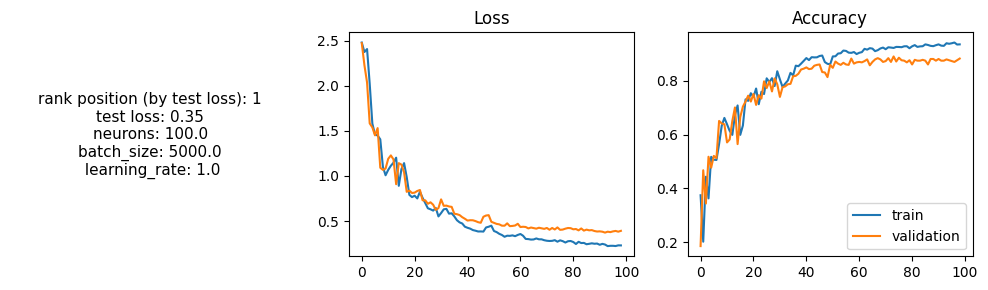

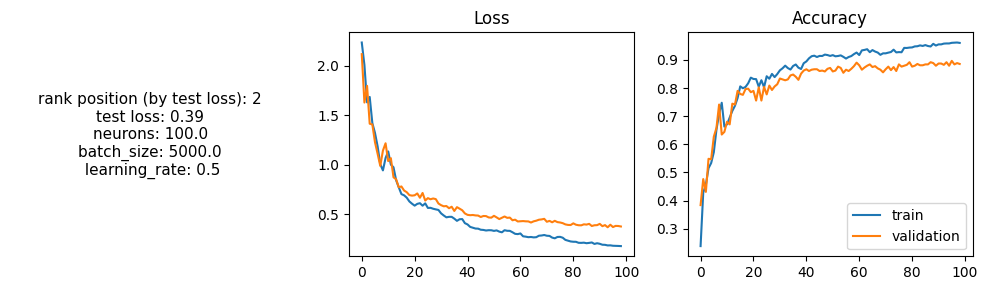

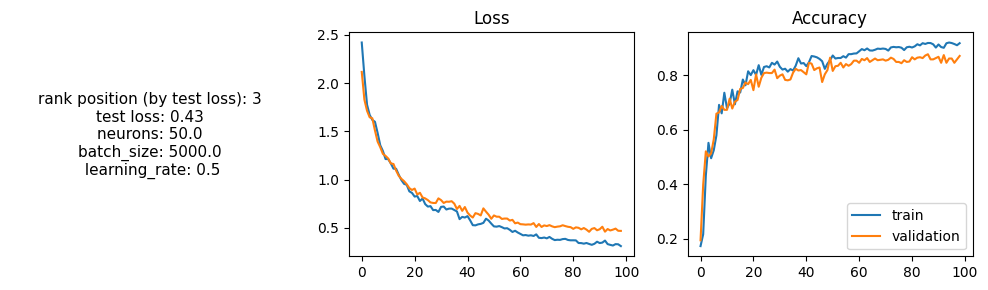

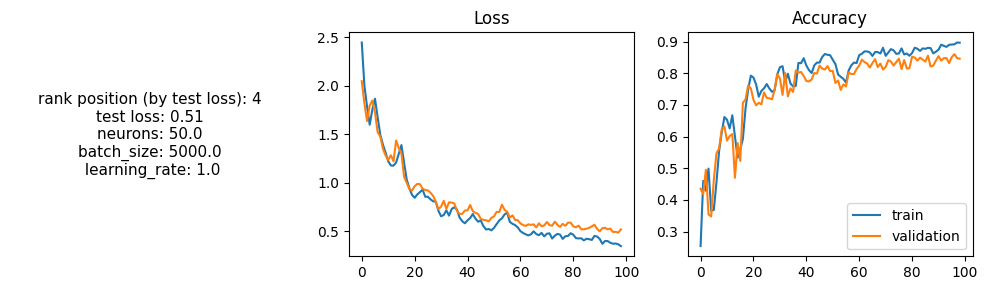

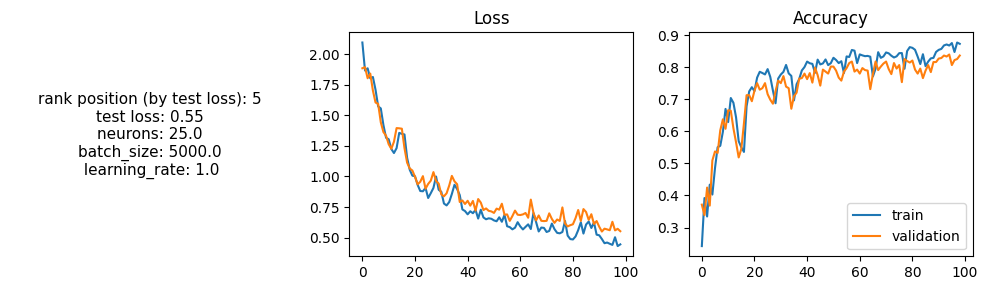

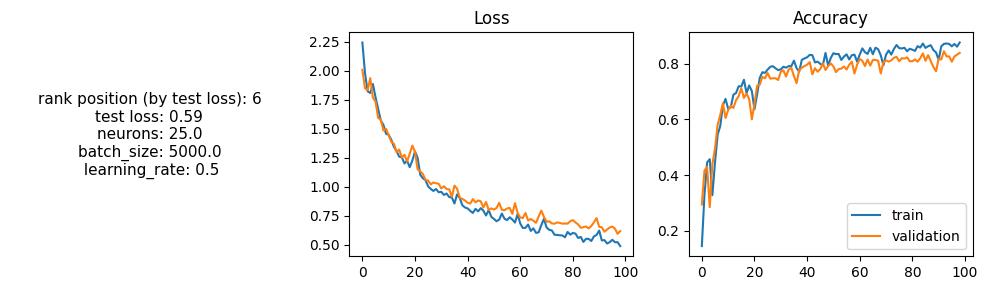

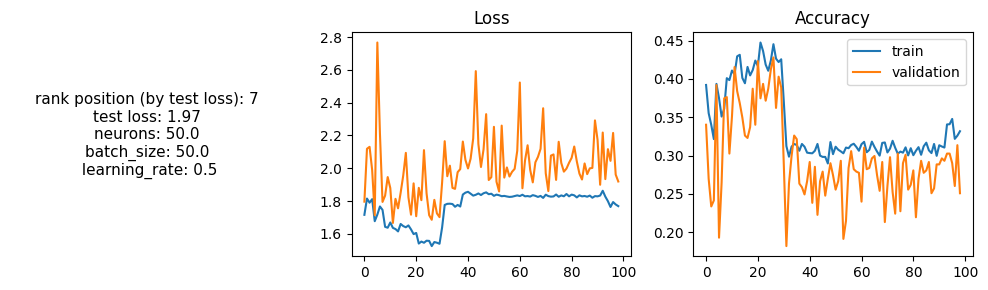

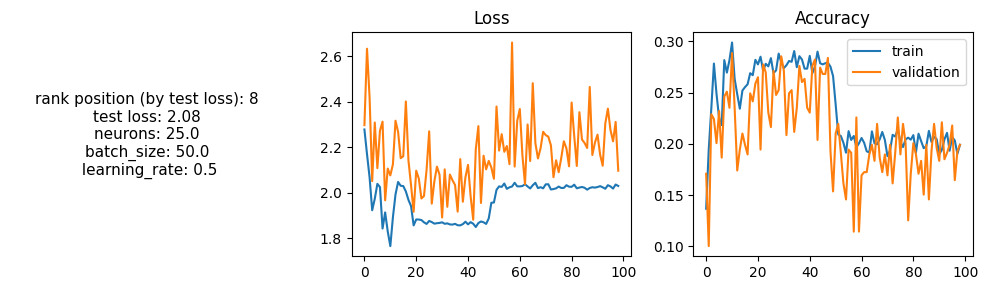

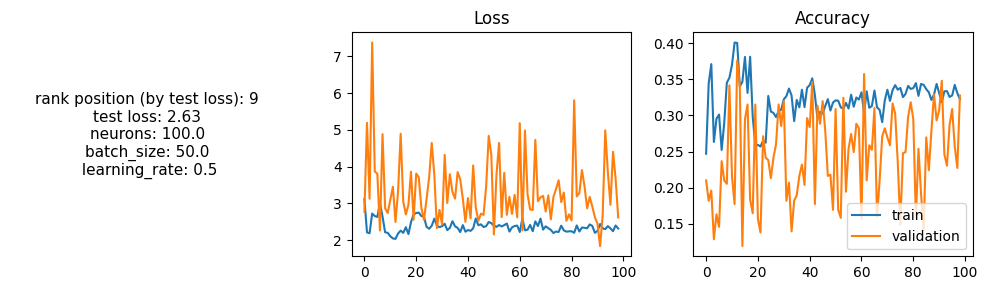

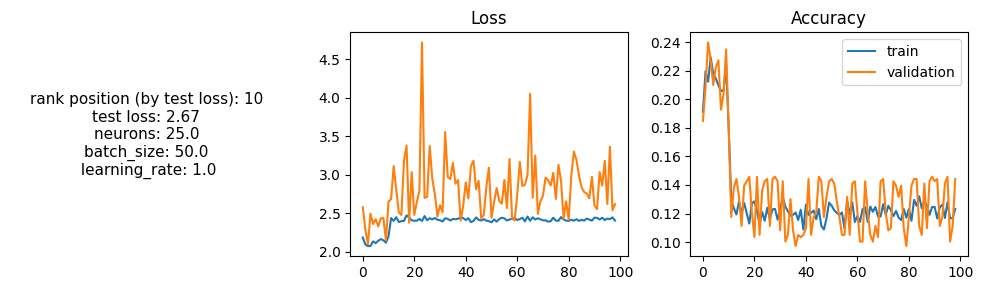

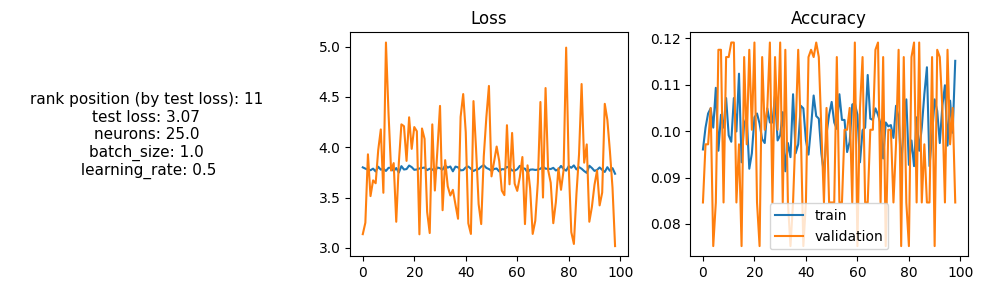

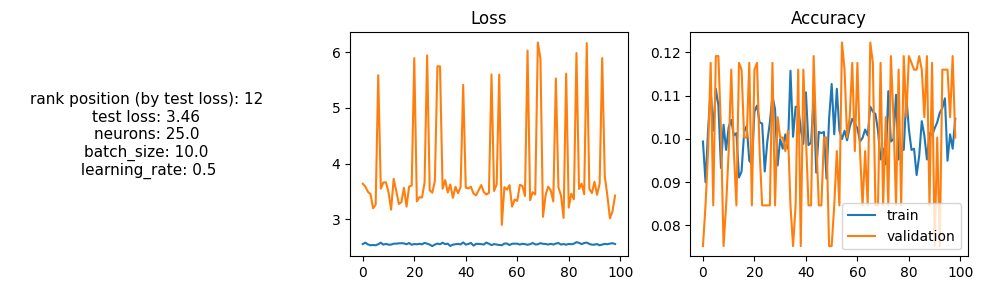

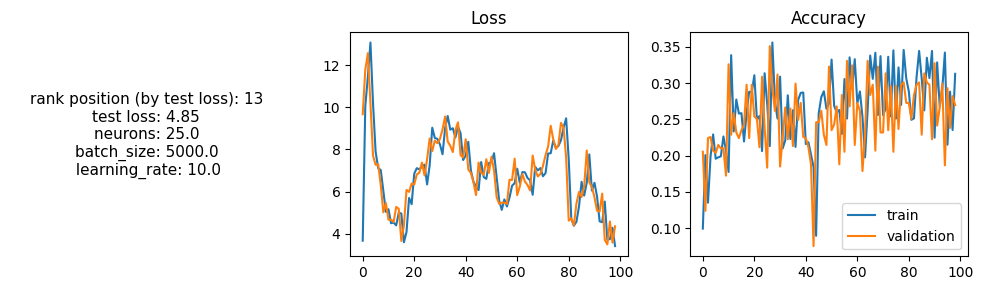

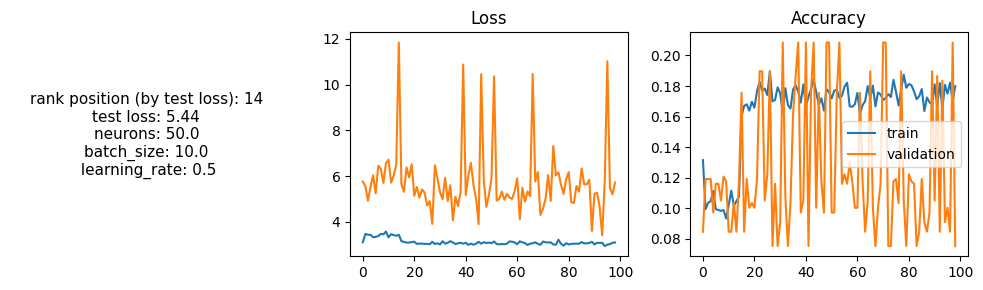

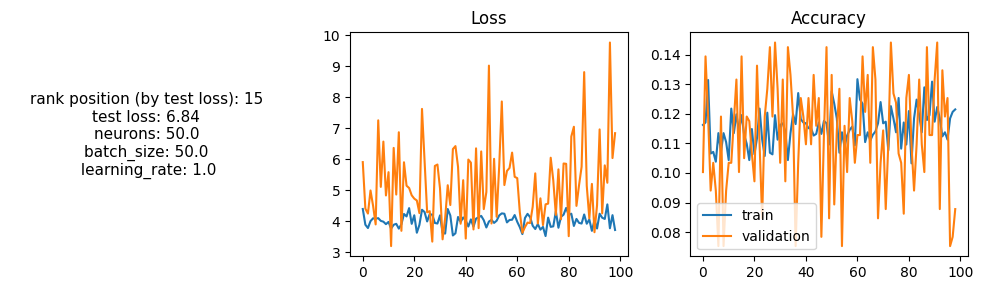

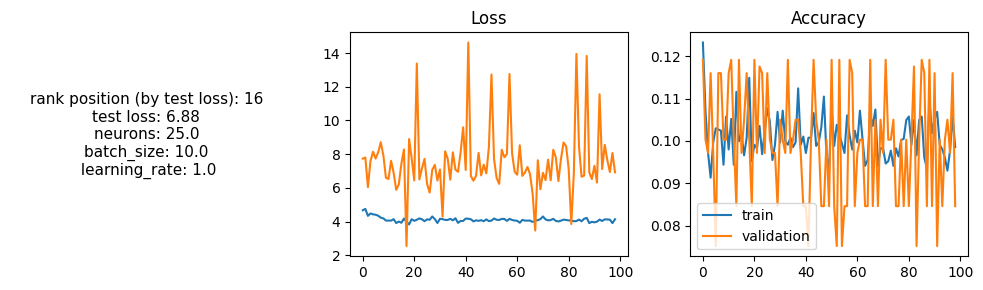

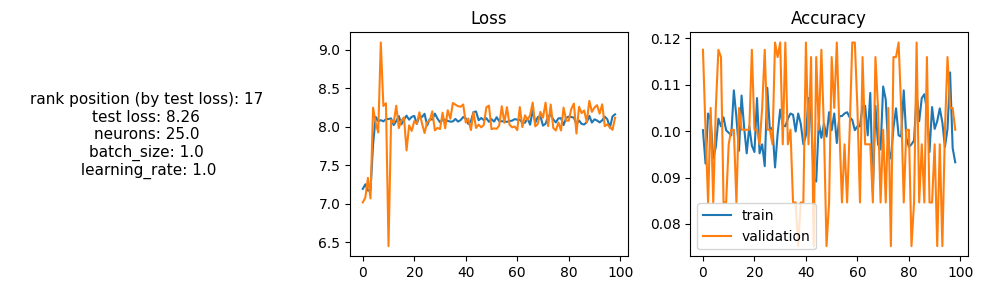

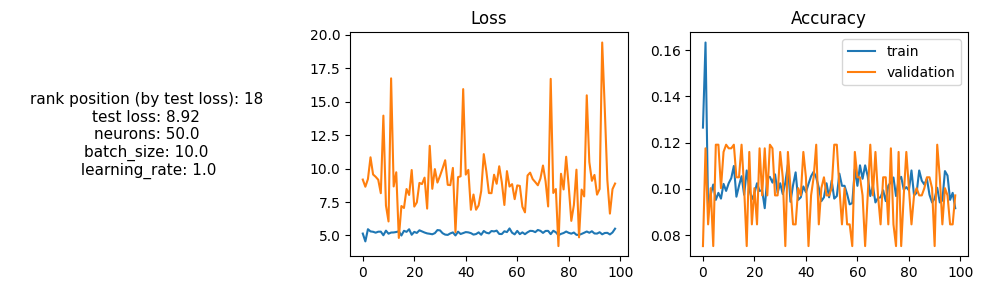

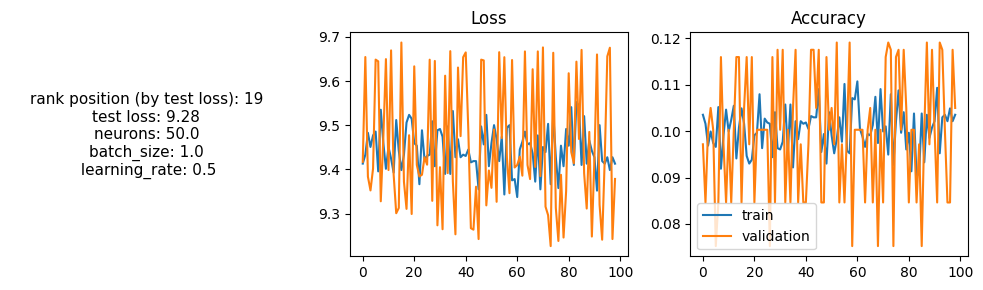

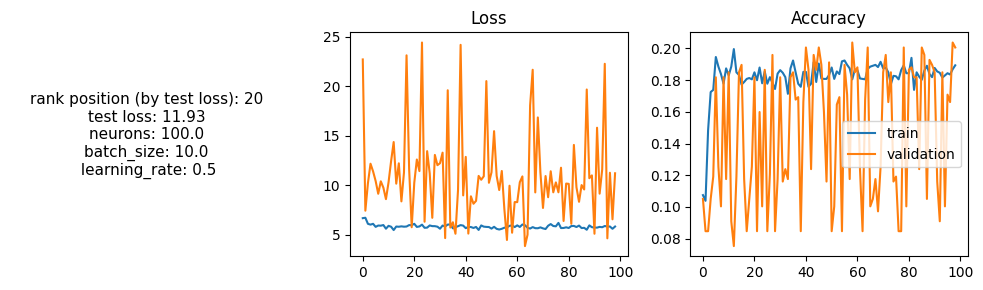

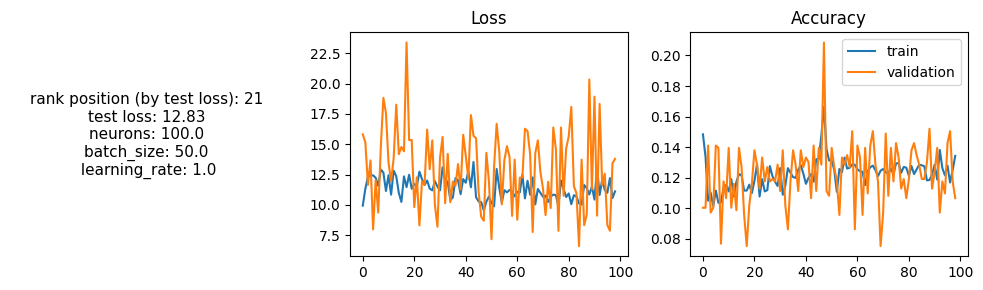

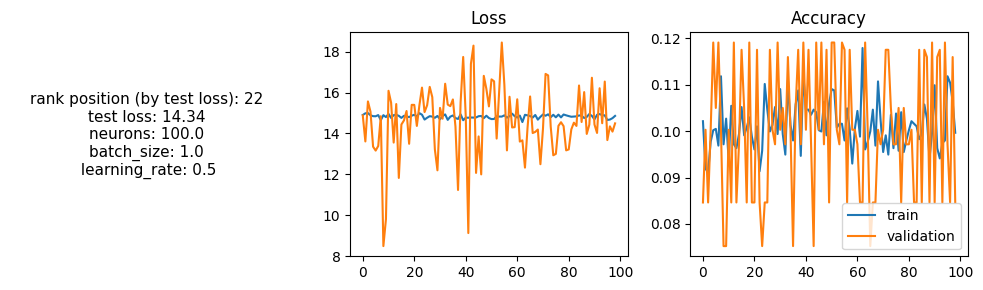

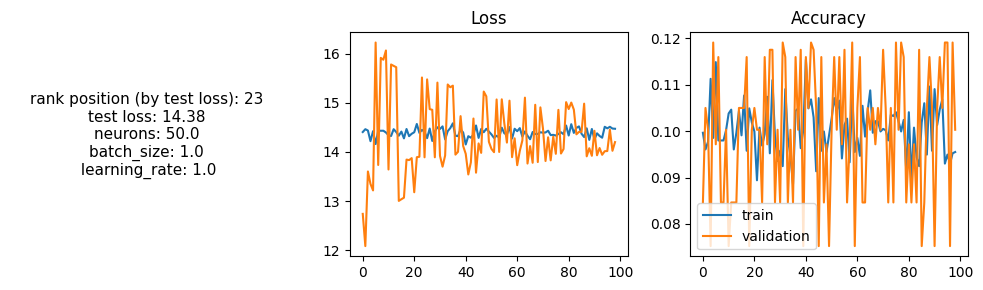

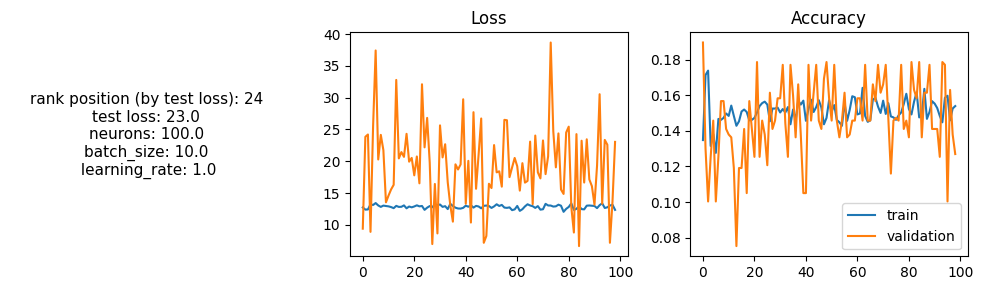

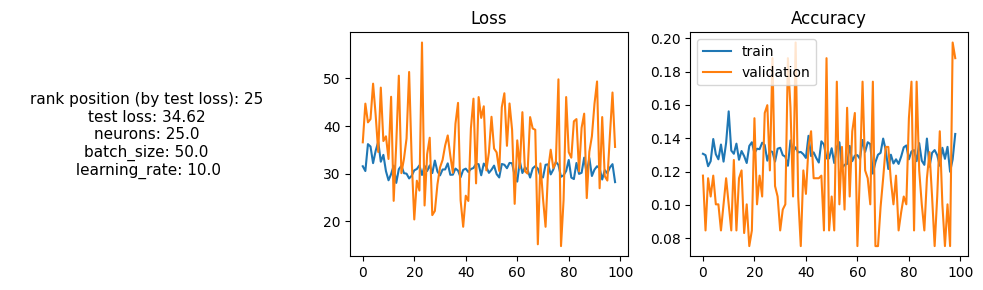

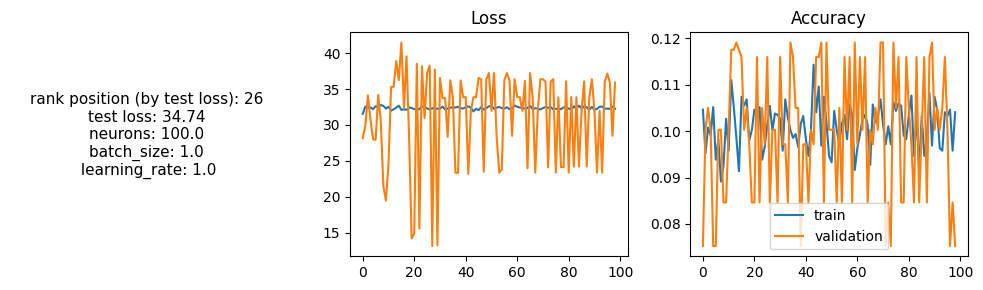

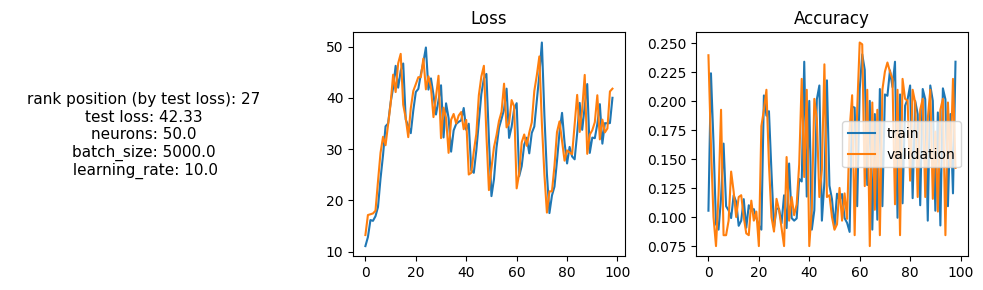

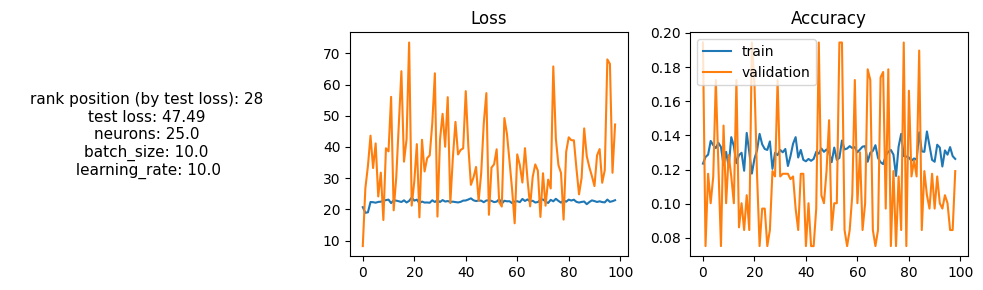

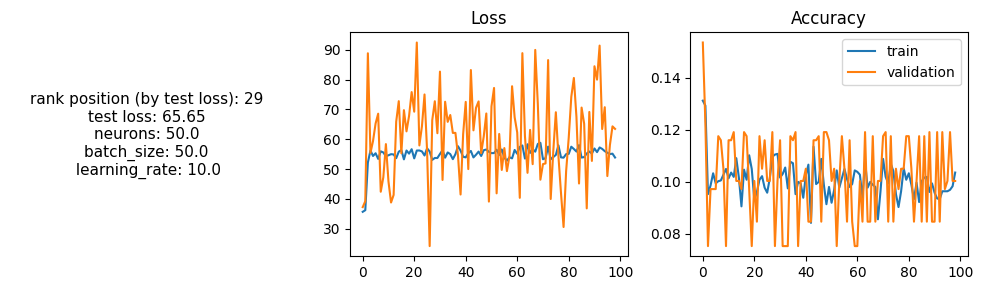

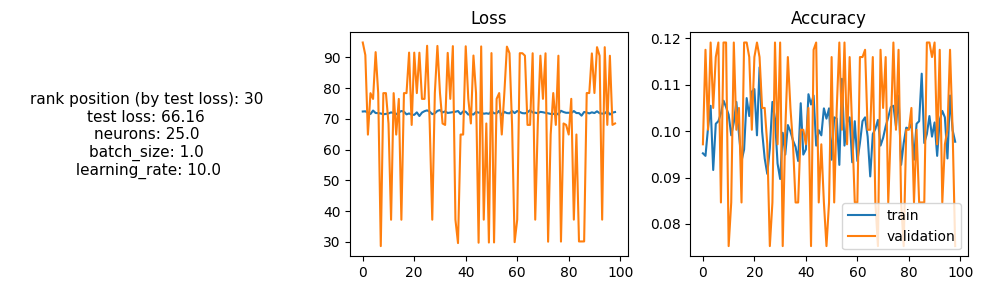

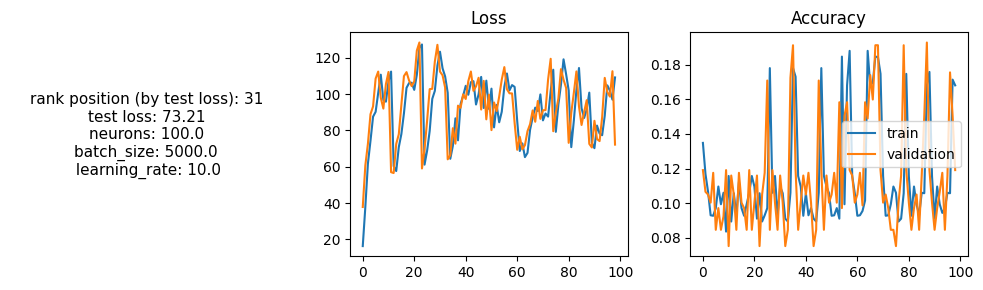

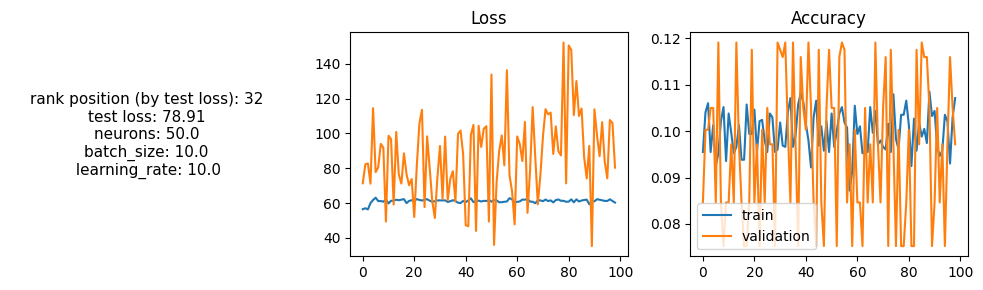

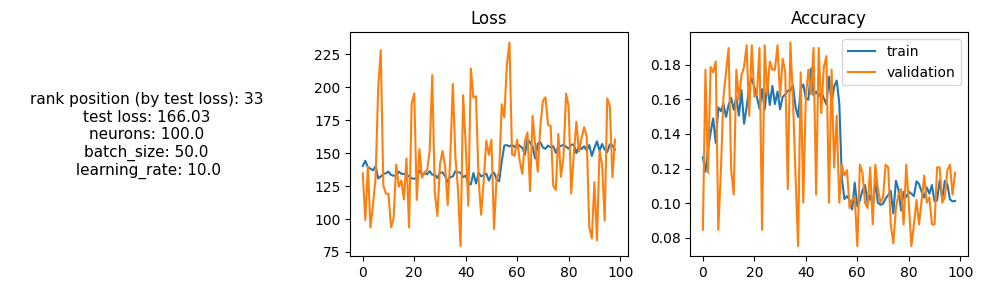

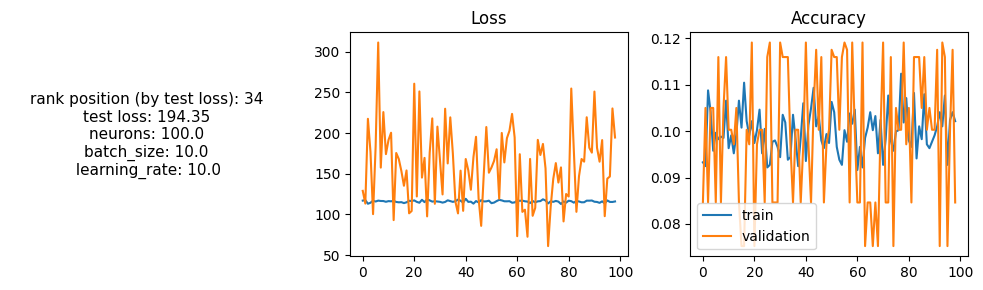

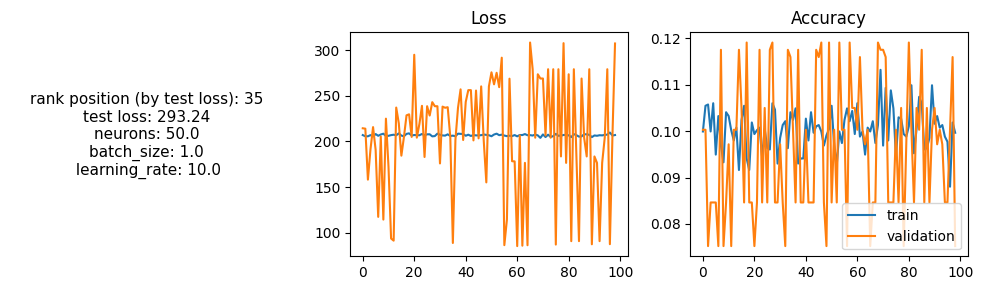

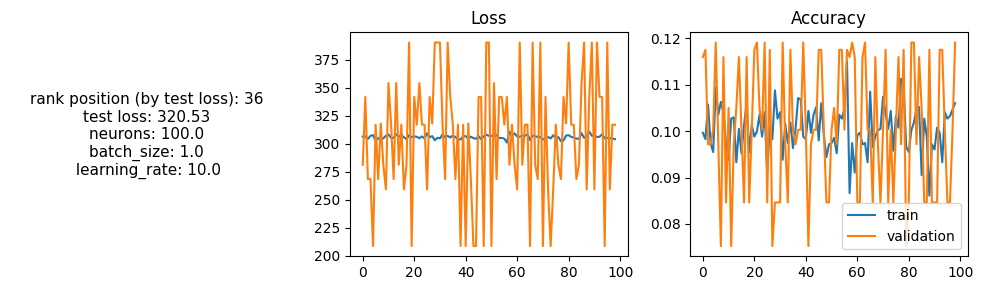

In [7]:
for idx, row in results.iterrows():
    
    index = int(row['index'])
    
    title = f"rank position (by test loss): {idx + 1} \n"
    title += f"test loss: {row['test_loss']} \n"
    title += f"neurons: {row['n_neurons']} \n"
    title += f"batch_size: {row['batch_size']} \n "
    title += f"learning_rate: {row['learning_rate']} \n"
    
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=[10,3])
    
    
    ax[0].text(0.5, 0.5, title, horizontalalignment='center', verticalalignment='center', 
               fontsize=11, transform=ax[0].transAxes)
    ax[0].axis('off')
    
    ax[1].plot(histories[index]['loss'][1:], label='train')
    ax[1].plot(histories[index]['val_loss'][1:], label='validation')
    
    ax[1].set_title("Loss")

    ax[2].plot(histories[index]['accuracy'][1:], label='train')
    ax[2].plot(histories[index]['val_accuracy'][1:], label='validation')
    ax[2].set_title("Accuracy")
    
    
    
    plt.legend()
    #print(title)
    fig.tight_layout()
    plt.show()


<span style='color: blue; font-size:14pt'> 
Interpretações dos históricos de losses, em relação ao resultado final obtido: <br>
(ranqueamento com base no valor da loss de teste)<hr>

Podemos notar que apenas as 6 primeiras execuções houveram um aprendizado constante, em que a loss do treino e da validação caíam juntas, até que começam a se separar, pois o modelo se especifica em detalhes do treino que não generalizam, e é o momento de parar de treinar. Usamos o restore_best_weights para que quando isso aconteça, possamos voltar e pegar o melhor resultado.
    
É interessante notar que apenas os 6 primeiros gráficos não apresentaram um comportamento fora do normal na loss do dataset de validação (considere fora do normal essas retas que sobem e descem abruptamente, sem controle). Isso ocorreu provavelmente porque usamos taxas de aprendizado muito grandes em nossos testes, e com isso, somente o Gradient Descent conseguiu convergir (batch size de 5000), pois o uso do SGD atualizaria os pesos com base em cada entrada, e com essa taxa de aprendizado alta ele não seguia para um mínimo local adequado. 
    
Além disso, o valor de learning rate 10 não conseguiu convergir sequer com uso do GD, sendo que essa taxa trouxe, inclusive, os piores resultados de todos os testes.
    
É válido um último teste para comprovação dessa hipótese, modificando essa taxa de aprendizado, e verificando se o SGD e o Batch SGD começam a se tornar mais atrativos. Faremos esse teste extra a seguir.
</span>


#### Teste extra: uso de uma Taxas de Aprendizado menor para validar nossa hipótese 

In [23]:
new_results = pd.DataFrame()
new_histories = []

In [24]:
# Taxa de aprendizado menor
learning_rate = 1e-2

for n_neurons in n_neurons_list:
    for batch_size in batch_size_list:

            print("=" * 100)
            start = time.time()

            model = create_model(n_neurons, learning_rate)

            # Treino do modelo. Aqui estamos aplicando a variação do batch_size
            # e usando os 15% de tamanho do df de validação
            history = model.fit(x=X_train, 
                                y=y_train, 
                                validation_split=0.15,
                                epochs=epochs, 
                                batch_size=batch_size, 
                                callbacks=[early_stop],
                                verbose=0)

            # Avaliação do modelo no dado fora da amostra, para avaliar apenas a saída final
            # no dataset results
            loss, accuracy = model.evaluate(X_test, y_test)

            time_spent = round(time.time() - start, 2)

            single_output = pd.DataFrame.from_dict({
                'n_neurons': [n_neurons],
                'batch_size': [batch_size],
                'learning_rate': [learning_rate],
                'test_loss': [round(loss,2)],
                'test_accuracy': [round(accuracy, 2)],
                'time_spent': [time_spent]
            })

            display(single_output)
            print(f"Time spent: {time_spent} seconds.")

            new_results = new_results.append(single_output)
            new_results.to_csv("results_new.csv", index=False)

            new_histories.append(history.history)
            with open('histories_new.pkl','wb') as f:
                pkl.dump(histories, f)

            print("Done!")

24/24 [==============================] - 0s 2ms/step - loss: 2.1609 - accuracy: 0.1600


n_neurons  batch_size  learning_rate  test_loss  test_accuracy  time_spent
0         25           1           0.01       2.16           0.16      709.69

Time spent: 709.69 seconds.
Done!
24/24 [==============================] - 0s 2ms/step - loss: 0.6121 - accuracy: 0.8093


n_neurons  batch_size  learning_rate  test_loss  test_accuracy  time_spent
0         25          10           0.01       0.61           0.81       69.87

Time spent: 69.87 seconds.
Done!
24/24 [==============================] - 0s 2ms/step - loss: 0.4616 - accuracy: 0.8653


n_neurons  batch_size  learning_rate  test_loss  test_accuracy  time_spent
0         25          50           0.01       0.46           0.87       17.35

Time spent: 17.35 seconds.
Done!
24/24 [==============================] - 0s 1ms/step - loss: 1.7689 - accuracy: 0.4867


n_neurons  batch_size  learning_rate  test_loss  test_accuracy  time_spent
0         25        5000           0.01       1.77           0.49        5.31

Time spent: 5.31 seconds.
Done!
24/24 [==============================] - 0s 2ms/step - loss: 2.0750 - accuracy: 0.2093


n_neurons  batch_size  learning_rate  test_loss  test_accuracy  time_spent
0         50           1           0.01       2.08           0.21      510.87

Time spent: 510.87 seconds.
Done!
24/24 [==============================] - 0s 1ms/step - loss: 0.5741 - accuracy: 0.8120


n_neurons  batch_size  learning_rate  test_loss  test_accuracy  time_spent
0         50          10           0.01       0.57           0.81       55.23

Time spent: 55.23 seconds.
Done!
24/24 [==============================] - 0s 1ms/step - loss: 0.3753 - accuracy: 0.8920


n_neurons  batch_size  learning_rate  test_loss  test_accuracy  time_spent
0         50          50           0.01       0.38           0.89       16.07

Time spent: 16.07 seconds.
Done!
24/24 [==============================] - 0s 2ms/step - loss: 1.7054 - accuracy: 0.4960


n_neurons  batch_size  learning_rate  test_loss  test_accuracy  time_spent
0         50        5000           0.01       1.71            0.5        5.78

Time spent: 5.78 seconds.
Done!
24/24 [==============================] - 0s 2ms/step - loss: 1.6570 - accuracy: 0.3653


n_neurons  batch_size  learning_rate  test_loss  test_accuracy  time_spent
0        100           1           0.01       1.66           0.37      540.69

Time spent: 540.69 seconds.
Done!
24/24 [==============================] - 0s 2ms/step - loss: 0.4194 - accuracy: 0.8760


n_neurons  batch_size  learning_rate  test_loss  test_accuracy  time_spent
0        100          10           0.01       0.42           0.88       62.57

Time spent: 62.57 seconds.
Done!
24/24 [==============================] - 0s 1ms/step - loss: 0.3595 - accuracy: 0.8867


n_neurons  batch_size  learning_rate  test_loss  test_accuracy  time_spent
0        100          50           0.01       0.36           0.89       17.26

Time spent: 17.26 seconds.
Done!
24/24 [==============================] - 0s 1ms/step - loss: 1.5052 - accuracy: 0.5853


n_neurons  batch_size  learning_rate  test_loss  test_accuracy  time_spent
0        100        5000           0.01       1.51           0.59        5.15

Time spent: 5.15 seconds.
Done!


#### Resultados de loss no dado de teste (ordenando do menor, que é melhor, pro maior)

In [25]:
new_results = pd.read_csv("results_new.csv")

new_results = new_results.sort_values(by=['test_loss'])

display(new_results)

new_results = new_results.reset_index(drop=False)

n_neurons  batch_size  learning_rate  test_loss  test_accuracy  time_spent
10        100          50           0.01       0.36           0.89       17.26
6          50          50           0.01       0.38           0.89       16.07
9         100          10           0.01       0.42           0.88       62.57
2          25          50           0.01       0.46           0.87       17.35
5          50          10           0.01       0.57           0.81       55.23
1          25          10           0.01       0.61           0.81       69.87
11        100        5000           0.01       1.51           0.59        5.15
8         100           1           0.01       1.66           0.37      540.69
7          50        5000           0.01       1.71           0.50        5.78
3          25        5000           0.01       1.77           0.49        5.31
4          50           1           0.01       2.08           0.21      510.87
0          25           1           0.01       2.16           0.16      709.69

#### Comparação das losses em cada época de treinamento (ordenando usando a tabela acima, para vermos os melhores resultados de saída primeiro)

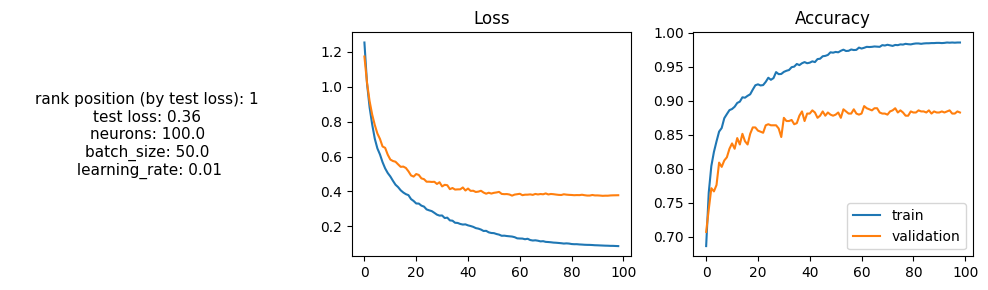

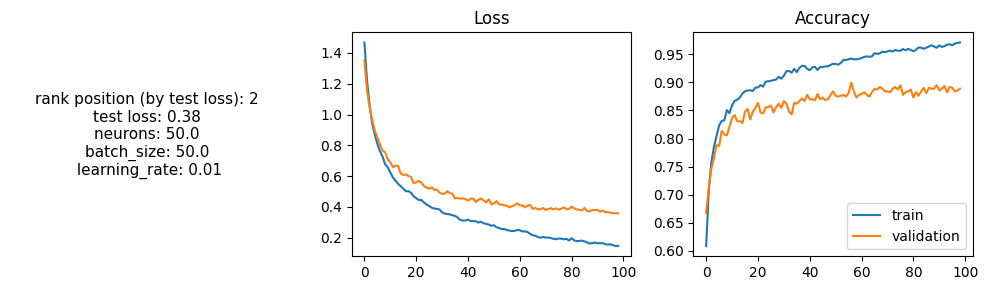

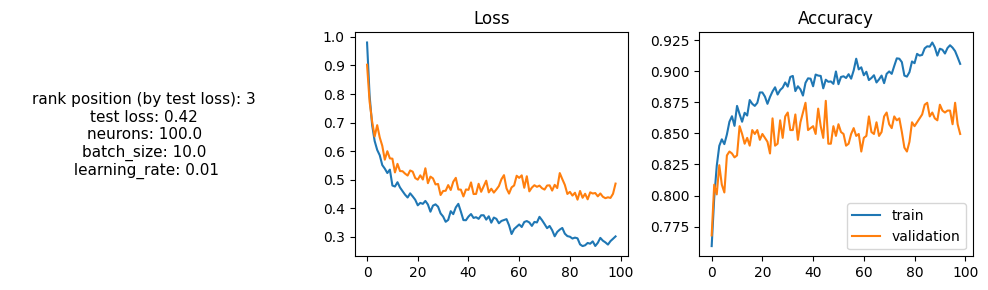

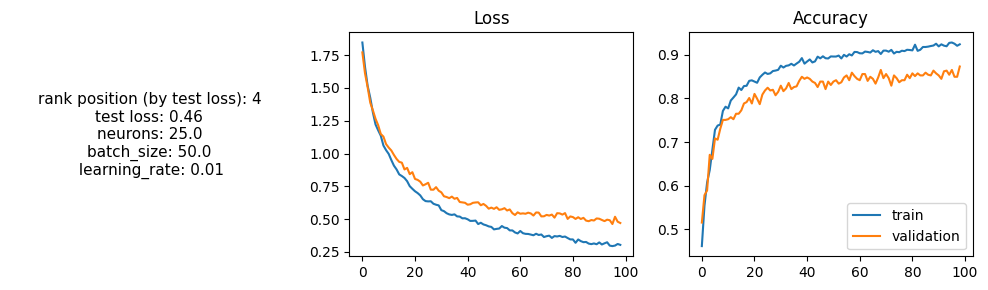

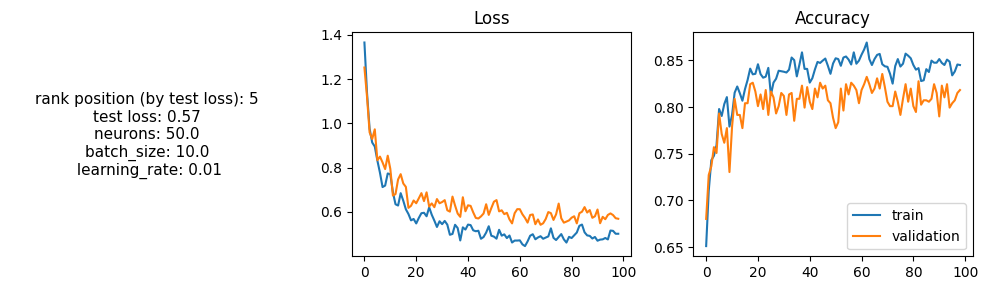

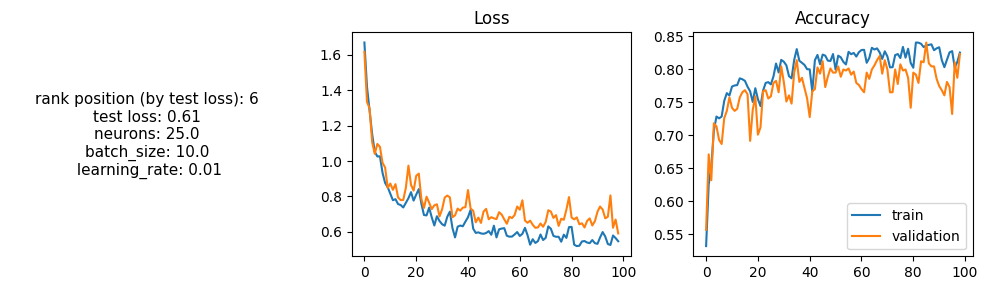

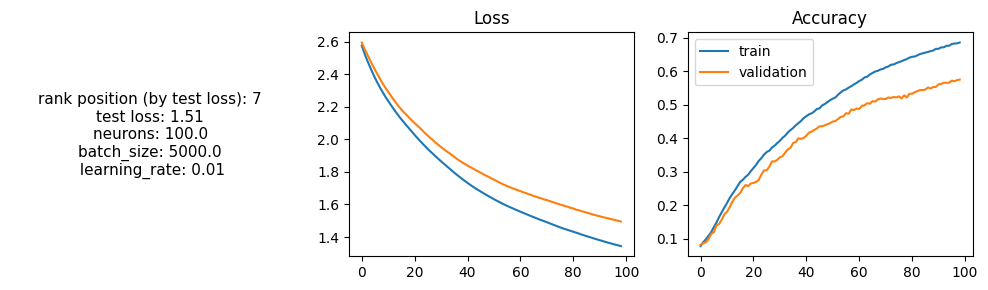

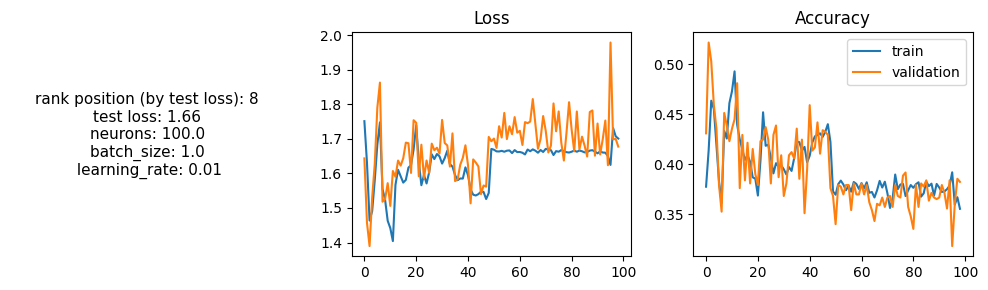

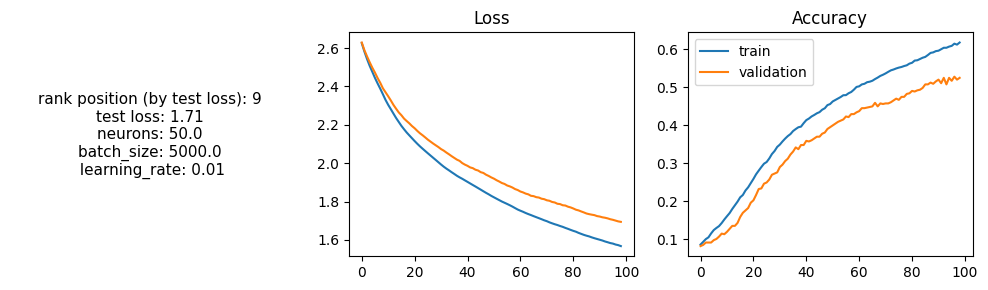

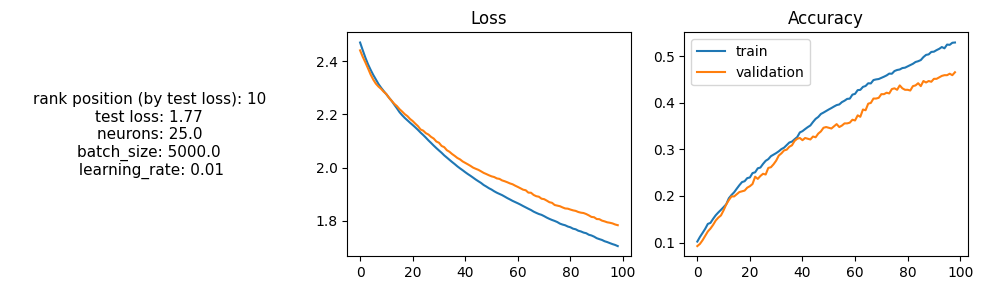

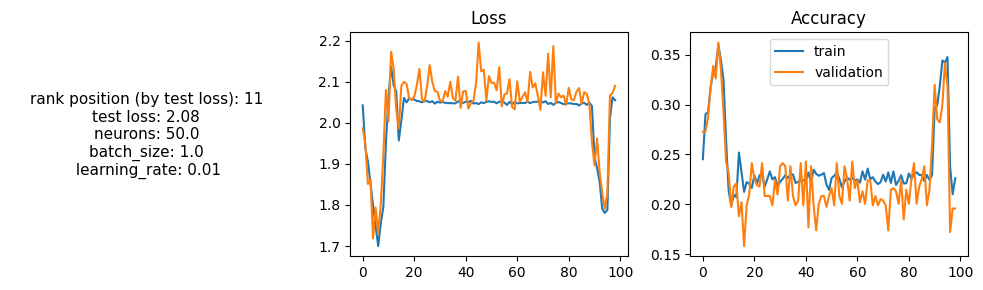

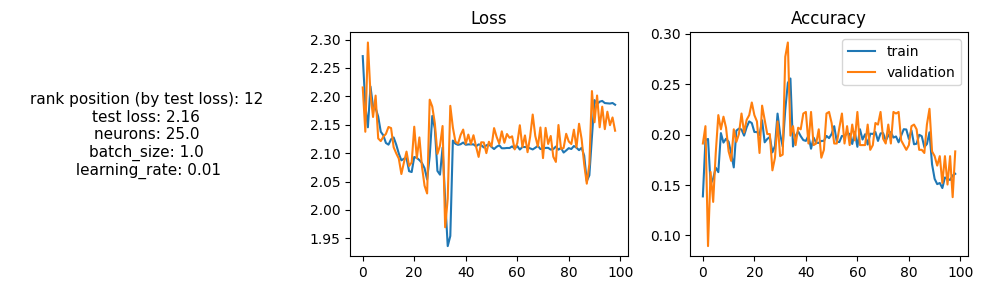

In [26]:
for idx, row in new_results.iterrows():
    
    index = int(row['index'])
    
    title = f"rank position (by test loss): {idx + 1} \n"
    title += f"test loss: {row['test_loss']} \n"
    title += f"neurons: {row['n_neurons']} \n"
    title += f"batch_size: {row['batch_size']} \n "
    title += f"learning_rate: {row['learning_rate']} \n"
    
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=[10,3])
    
    
    ax[0].text(0.5, 0.5, title, horizontalalignment='center', verticalalignment='center', 
               fontsize=11, transform=ax[0].transAxes)
    ax[0].axis('off')
    
    ax[1].plot(new_histories[index]['loss'][1:], label='train')
    ax[1].plot(new_histories[index]['val_loss'][1:], label='validation')
    
    ax[1].set_title("Loss")

    ax[2].plot(new_histories[index]['accuracy'][1:], label='train')
    ax[2].plot(new_histories[index]['val_accuracy'][1:], label='validation')
    ax[2].set_title("Accuracy")
    
    
    
    plt.legend()
    #print(title)
    fig.tight_layout()
    plt.show()


<span style='color: blue; font-size:14pt'> 
Interpretações com uso de uma taxa de aprendizado menor (0.01): <hr>
O uso de uma taxa de aprendizado menor fez com que o SGD e o Batch SGD começasse a performar melhor que o GD nesses testes. O valor final de loss ficou em 0,36 no melhor caso usando o Batch SGD, contra 0,35 do melhor que obtivemos nos primeiros testes feitos. O resultado poderia ter sido melhor com um uso de mais épocas durante o treinamento em alguns casos, pois a loss do treino e da validação não alcançaram seu melhor resultado. Portanto, uma learning rate menor foi capaz de trazer melhor resultado, mas precisaríamos de mais tempo rodando para chegar nesses casos.

Outra consideração importante, é que os tempos ficaram maiores no Batch SGD e no SGD, mas isso é porque nossa contagem de épocas foi fixa nos testes. Podemos observar que a loss chegou no valor mínimo logo nas primeiras épocas, mas manteve o treinamento porque não deixamos ativado o early stopping, por exemplo. Isso teria trazido o melhor resultado, sem precisar de todo esse tempo gasto.
</span>

##### Conclusão 

Esse trabalho mostrou que conseguimos resolver com uma acurácia atual de 89% o dataset MNIST, usando uma rede relativamente simples, de apenas 1 camada oculta, com 100 neurônios no maior cenário.

As taxas de aprendizado inicialmente testadas são muito grandes, e em vários casos não conseguiram convergir, fazendo com que a loss de treino e validação ficassem com oscilações que demonstravam falha de sucesso do algoritmo, nos casos em que a taxa de atualização de pesos fosse o SGD ou o Batch SGD, ou caso o número de neurônios fosse maior.

Usar uma taxa de aprendizado menor (teste extra) fez com que o SGD e o Batch SGD começassem a convergir, e poderíamos, inclusive, testar mais neurônios para tentar novos resultados melhores, e mais épocas, em alguns casos, para dar tempo pro algoritmo aprender melhor.